In [1]:
Needs["NDSolve`FEM`"]

In [2]:
Subscript[c, air] = QuantityMagnitude[ThermodynamicData["Air", "SoundSpeed"]];
Subscript[\[Rho], air] = QuantityMagnitude[ThermodynamicData["Air", "Density"]];

In [6]:
vars = {p[x, y], \[Omega], {x, y}};
pars = <|"SoundSpeed" -> Subscript[c, air], "MassDensity" -> Subscript[\[Rho], air]|>;
FrequencyAcousticsModel = AcousticPDEComponent[vars, pars]

-6  2
-7.04219 10   ω  p[x, y] + Inactive[Div][{{-0.830168, 0.}, {0., -0.830168}} . 
 
>     Inactive[Grad][p[x, y], {x, y}], {x, y}]

In [9]:
t = a/2;
\[Theta] = ArcTan[(b - a)/l];
parametersRules = {r -> 1, a -> 1/15, b -> 3/10, l -> 1/2, d -> 1/2};

In [22]:
rec1 = Rectangle[{-r, a}, {-r + d, a + t}];
rec2 = Polygon @@ (RotationTransform[\[Theta], {-r + d, a}][#] & /@ 
    (List @@ RegionBoundary[Rectangle[{-r + d, a}, {-r + d + l/Cos[\[Theta]], a + t}]]));
\[CapitalOmega] = RegionDifference[Disk[{0, 0}, r, {0, \[Pi]}], RegionUnion[rec1, rec2]] /. parametersRules;

In [25]:
\[Lambda] = (c/Subscript[f, max]) /. {c -> Subscript[c, air], Subscript[f, max] -> 1000};
h = \[Lambda]/12;

In [27]:
mesh = ToElementMesh[\[CapitalOmega], MaxCellMeasure -> {"Length" -> h}]

ElementMesh[{{-1., 1.}, {0., 1.}}, {TriangleElement[<13733>]}]

In [28]:
inlet = Circle[{0, 0}, r, {\[Pi] - ArcSin[a/r], \[Pi]}] /. parametersRules;
Subscript[\[CapitalGamma], in] = 
  AcousticRadiationValue[{x, y} \[Element] inlet, vars, 
   pars, <|"SoundIncidentPressure" -> 1|>];

In [30]:
outlet = Circle[{0, 0}, r, {0, \[Pi] - ArcSin[(a + t)/r]}] /. 
  parametersRules; Subscript[\[CapitalGamma], out] = 
 AcousticAbsorbingValue[{x, y} \[Element] outlet, vars, 
   pars, <|"AcousticSourceDistance" -> 1/(2 r)|>] /. parametersRules;

-6  2
-7.04219 10   ω  p[x, y] + Inactive[Div][{{-0.830168, 0.}, {0., -0.830168}} . 
 
>      Inactive[Grad][p[x, y], {x, y}], {x, y}] == 
 
>   NeumannValue[(0. + 0.00241789 I) ω 
 
                                                BoundaryUnitNormal[x, y]
>      (1. + BoundaryUnitNormal[x, y] . (--------------------------------------) - 
                                                                            2
                                         Sqrt[Total[BoundaryUnitNormal[x, y] ]]
 
                                                              1
>        1. p[x, y]), {x, y} ∈ Circle[{0, 0}, 1, {Pi - ArcSin[--], Pi}]] + 
                                                              15
 
>    NeumannValue[-0.415084 p[x, y] - (0. + 0.00241789 I) ω p[x, y], 
 
                                                 1
>     {x, y} ∈ Circle[{0, 0}, 1, {0, Pi - ArcSin[--]}]]
                                                 10
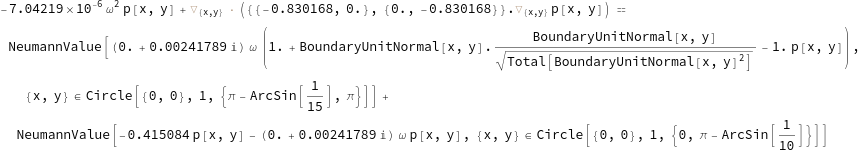

In [31]:
pde = FrequencyAcousticsModel == Subscript[\[CapitalGamma], in] + Subscript[\[CapitalGamma], out]

In [32]:
fRange = Table[f, {f, 50, 1000, 10}];
pfun = ParametricNDSolveValue[pde, p, {x, y} \[Element] mesh, {\[Omega]}];
Monitor[pfunTable = Table[pfun[\[Omega]] /. {\[Omega] -> 2 \[Pi] f}, {f, fRange}], Row[{"frequency being solved = ", CForm[f], " Hz"}]];

In [46]:
f = 900;
{index} = Flatten[Position[fRange, f]];

In [48]:
pMax = Max[Abs[pfunTable[[index]]["ValuesOnGrid"]]];
legendBar = BarLegend[{"TemperatureMap", {-pMax, pMax}}, Sequence[50, LegendLabel -> Style["[Pa]", Opacity[0.6]]]];
options = {PlotRange -> {-pMax, pMax}, Sequence[
   ColorFunction -> ColorData[{"TemperatureMap", {-pMax, pMax}}], 
    ContourStyle -> None, ColorFunctionScaling -> False, 
    Contours -> 30, PlotPoints -> 41, FrameLabel -> {"x", "y"}, 
    PlotLabel -> Style["Transient sound pressure: p(x,y)", 18], 
    AspectRatio -> Automatic, ImageSize -> Medium]};

In [51]:
boundaryHighlight1 = Graphics[{{Dashed, 
    Circle[{0, 0}, r, {0, Pi - ArcSin[(a + t)/r]}]}, 
    Circle[{0, 0}, r, {Pi - ArcSin[a/r], Pi}], 
    Line[{{-r, 0}, {r, 0}}], 
    Line[{{-r, a}, 
          {-r + d, a}, 
          {-r + d + l, a + l Tan[\[Theta]]}, 
          {-r + d + l - t Sin[\[Theta]], a + l Tan[\[Theta]] + t Cos[\[Theta]]}, 
          {-r + d - t Sin[\\[Theta]], a + t}, 
          {-Sqrt[r^2 - (a + t)^2], a + t}}]
}] /. parametersRules;

ToExpression::sntx: Invalid syntax in or before "                                                                                                                                                                                                                                                                                                                                                                          ^".


$Failed

In [55]:
nframes = 50;
frames = Table[
   Show[Legended[
     ContourPlot[
      Re[pfunTable[[index]][x, y]*
         Exp[I \[Omega] t] /. {\[Omega] -> 2 \[Pi] f}], {x, 
        y} \[Element] \[CapitalOmega], Evaluate[options]], legendBar],
     boundaryHighlight1], {t, 0, 0.002, 0.002/nframes}];
frames = Rasterize[#1, "Image", ImageResolution -> 80] & /@ frames;

Could not combine the graphics objects in `1`.: Could not combine the graphics objects in Show[-Graphics-, boundaryHighlight1].

Could not combine the graphics objects in `1`.: Could not combine the graphics objects in Show[-Graphics-, boundaryHighlight1].

Could not combine the graphics objects in `1`.: Could not combine the graphics objects in Show[-Graphics-, boundaryHighlight1].

Further output of `1` will be suppressed during this calculation.: Further output of Show::gcomb will be suppressed during this calculation.

Manipulate[PaneSelector[{1 -> -Image-, 2 -> -Image-, 3 -> -Image-, 4 -> -Image-, 
 
>     5 -> -Image-, 6 -> -Image-, 7 -> -Image-, 8 -> -Image-, 9 -> -Image-, 
 
>     10 -> -Image-, 11 -> -Image-, 12 -> -Image-, 13 -> -Image-, 14 -> -Image-, 
 
>     15 -> -Image-, 16 -> -Image-, 17 -> -Image-, 18 -> -Image-, 19 -> -Image-, 
 
>     20 -> -Image-, 21 -> -Image-, 22 -> -Image-, 23 -> -Image-, 24 -> -Image-, 
 
>     25 -> -Image-, 26 -> -Image-, 27 -> -Image-, 28 -> -Image-, 29 -> -Image-, 
 
>     30 -> -Image-, 31 -> -Image-, 32 -> -Image-, 33 -> -Image-, 34 -> -Image-, 
 
>     35 -> -Image-, 36 -> -Image-, 37 -> -Image-, 38 -> -Image-, 39 -> -Image-, 
 
>     40 -> -Image-, 41 -> -Image-, 42 -> -Image-, 43 -> -Image-, 44 -> -Image-, 
 
>     45 -> -Image-, 46 -> -Image-, 47 -> -Image-, 48 -> -Image-, 49 -> -Image-, 
 
>     50 -> -Image-, 51 -> -Image-}, Dynamic[i3955], ImageSize -> All, 
 
>    Alignment -> Automatic, BaseStyle -> ListAnimateCore, 
 
>    TransitionDirection -> Horizontal, TransitionDuration -> 0.5, 
 
>    TransitionEffect -> Automatic], 
 
>   {{i3955, 1, }, 1, 51, 1, AnimationRate -> Automatic, DisplayAllSteps -> True, 
 
>    AppearanceElements -> 
 
>     {ProgressSlider, PlayPauseButton, FasterSlowerButtons, DirectionButton}}, 
 
>   SaveDefinitions -> True, ControlType -> Animator, AppearanceElements -> None, 
 
>   DefaultBaseStyle -> ListAnimate, DefaultLabelStyle -> ListAnimateLabel, 
 
>   SynchronousUpdating -> True, Method -> 
 
>    {DynamicCore -> False, TemplateExpand -> True}, 
 
>   Bookmarks -> {min :> {i3955 = 1}, max :> {i3955 = 51}}]
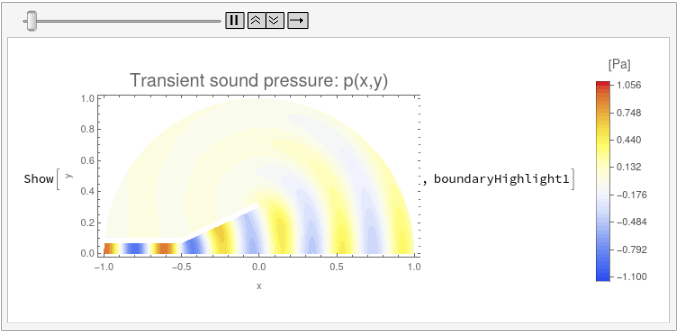

In [58]:
ListAnimate[Sequence[frames, SaveDefinitions -> True]]

In [59]:
R = 2;
{x0, y0} = {x, y} /. 
   Last[NSolve[{x^2 + (y - b)^2 == R^2, (x + r)^2 + (y - a)^2 == 
       R^2}, {x, y}]];
\[Phi] = VectorAngle[{-r - x0, a - y0}, {-x0, b - y0}];
\[Gamma] = 3/2 \[Pi] - VectorAngle[{0, -1}, {-r - x0, a - y0}];
curve = Annulus[{x0, y0}, {R - t, R}, {\[Gamma], \[Gamma] + \[Phi]}];
\[CapitalOmega]cur = 
  RegionDifference[Disk[{0, 0}, r, {0, \[Pi]}], curve] /. 
   parametersRules;

In [65]:
meshCur = 
 ToElementMesh[\[CapitalOmega]cur, MaxCellMeasure -> {"Length" -> h}]

ElementMesh[{{-1., 1.}, {0., 1.}}, {TriangleElement[<13802>]}]

In [66]:
pfun2 = ParametricNDSolveValue[pde, 
   p, {x, y} \[Element] meshCur, {\[Omega]}];
Monitor[pfunTable2 = 
   Table[pfun2[\[Omega]] /. {\[Omega] -> 2 \[Pi] f}, {f, fRange}], 
  Row[{"frequency being solved = ", CForm[f], " Hz"}]];

In [68]:
boundaryHighlight2 = Graphics[{{Dashed, outlet}, inlet, 
Line[{{-r, 0}, {r, 0}}], 
Circle[{x0, y0}, R, {\[Gamma], \[Gamma] + \[Phi]}], 
Circle[{x0, y0}, R - t, {\[Gamma], \[Gamma] + \[Phi]}], 
Line[{{0, b}, {
       x0 + (R - t) Cos[\[Gamma] + \[Phi]], 
        y0 + (R - t) Sin[\[Gamma] + \[Phi]]}}]}] /. parametersRules;

In [69]:
nframes = 50;
frames2 = Table[
   Show[Legended[
     ContourPlot[
      Re[pfunTable2[[index]][x, y]*
         Exp[I \[Omega] t] /. {\[Omega] -> 2 \[Pi] f}], {x, 
        y} \[Element] \[CapitalOmega]cur, Evaluate[options]], 
     legendBar], boundaryHighlight2], {t, 0, 0.002, 0.002/nframes}];
frames = Rasterize[#1, "Image", ImageResolution -> 80] & /@ frames;

Manipulate[PaneSelector[{1 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 2 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 3 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 4 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 5 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 6 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 7 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 8 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 9 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 10 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 11 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 12 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 13 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 14 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 15 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 16 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 17 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 18 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 19 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 20 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 21 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 22 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 23 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 24 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 25 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 26 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 27 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 28 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 29 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 30 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 31 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendLabel -> [Pa]]], 32 -> 
 
>      Legended[-Graphics-, BarLegend[{TemperatureMap, {-1.12839, 1.12839}}, 50, 
 
>        LegendL
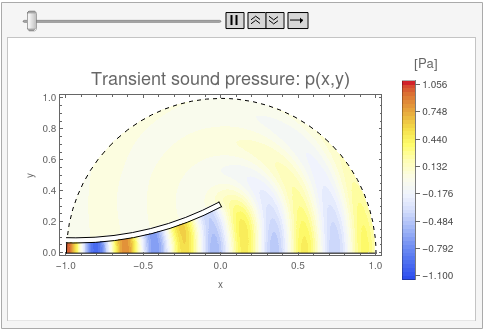

In [77]:
ListAnimate[
Sequence[frames2, SaveDefinitions -> True]]

In [73]:
Subscript[L, in] = N@ArcLength[inlet];

In [74]:
Jrec = Table[(Abs[NIntegrate[pfunTable[[i]][x, y], {x, y} \[Element] inlet]/ Subscript[L, in] - 1]), {i, fRange // Length}];
Jcur = Table[(Abs[NIntegrate[pfunTable2[[i]][x, y], {x, y} \[Element] inlet]/ Subscript[L, in] - 1]), {i, fRange // Length}];

-Graphics-
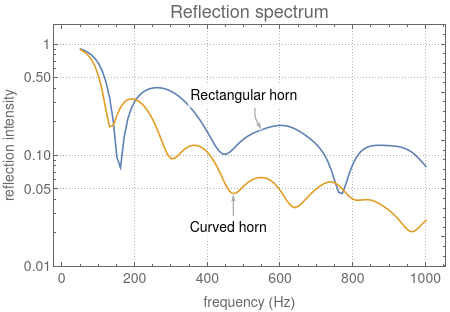

In [76]:
ListLogPlot[{
    Callout[Transpose[{fRange, Jrec}], Sequence[Style["Rectangular horn", 14], {500, Above}, 
    CalloutMarker -> Arrowheads[0.02]]], 
    Callout[Transpose[{fRange, Jcur}], Sequence[Style["Curved horn", 14], {500, Below}, 
    CalloutMarker -> Arrowheads[0.02]]]
}, Sequence[
    PlotLabel -> Style["Reflection spectrum", 18], 
    FrameLabel -> {"frequency (Hz)", "reflection intensity"}, 
    LabelStyle -> Directive[14], 
    ImageSize -> 450, 
    Joined -> True, 
    PlotRange -> {0.01, 1}, 
    PlotTheme -> "Detailed"
]]

In [4]:
Subscript[\[Rho], air]

1.20458

In [5]:
Subscript[c, air]

343.344

NeumannValue[(0. + 0.00241789 I) ω (1. + 
 
                                          BoundaryUnitNormal[x, y]
>      BoundaryUnitNormal[x, y] . (--------------------------------------) - 1. p[x, y])\
                                                                      2
                                   Sqrt[Total[BoundaryUnitNormal[x, y] ]]
 
                                               1
>    , {x, y} ∈ Circle[{0, 0}, 1, {Pi - ArcSin[--], Pi}]]
                                               15
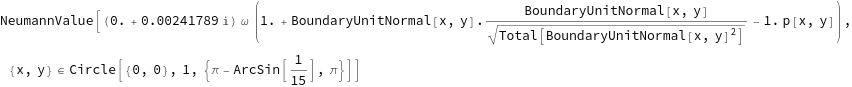

In [20]:
Subscript[\[CapitalGamma], in]

NeumannValue[-0.415084 p[x, y] - (0. + 0.00241789 I) ω p[x, y], 
 
                                               1
>   {x, y} ∈ Circle[{0, 0}, 1, {0, Pi - ArcSin[--]}]]
                                               10
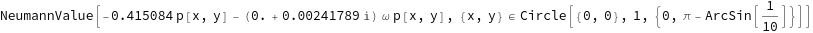

In [35]:
Subscript[\[CapitalGamma], out]